Aim: Write a program to implement single-stage Object Detection: SSD and Yolo

--2025-04-01 19:26:40--  https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/voc/MobileNetSSD_deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29353 (29K) [text/plain]
Saving to: ‘MobileNetSSD_deploy.prototxt’

MobileNetSSD_deploy 100%[===================>]  28.67K  --.-KB/s    in 0.003s  

2025-04-01 19:26:40 (10.8 MB/s) - ‘MobileNetSSD_deploy.prototxt’ saved [29353/29353]

--2025-04-01 19:26:41--  https://raw.githubusercontent.com/nikmart/pi-object-detection/master/MobileNetSSD_deploy.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

Saving ChatGPT Image Mar 30, 2025, 08_01_52 AM.png to ChatGPT Image Mar 30, 2025, 08_01_52 AM.png
Processing file: ChatGPT Image Mar 30, 2025, 08_01_52 AM.png
SSD inference time: 0.05 seconds
YOLO inference time: 2.19 seconds


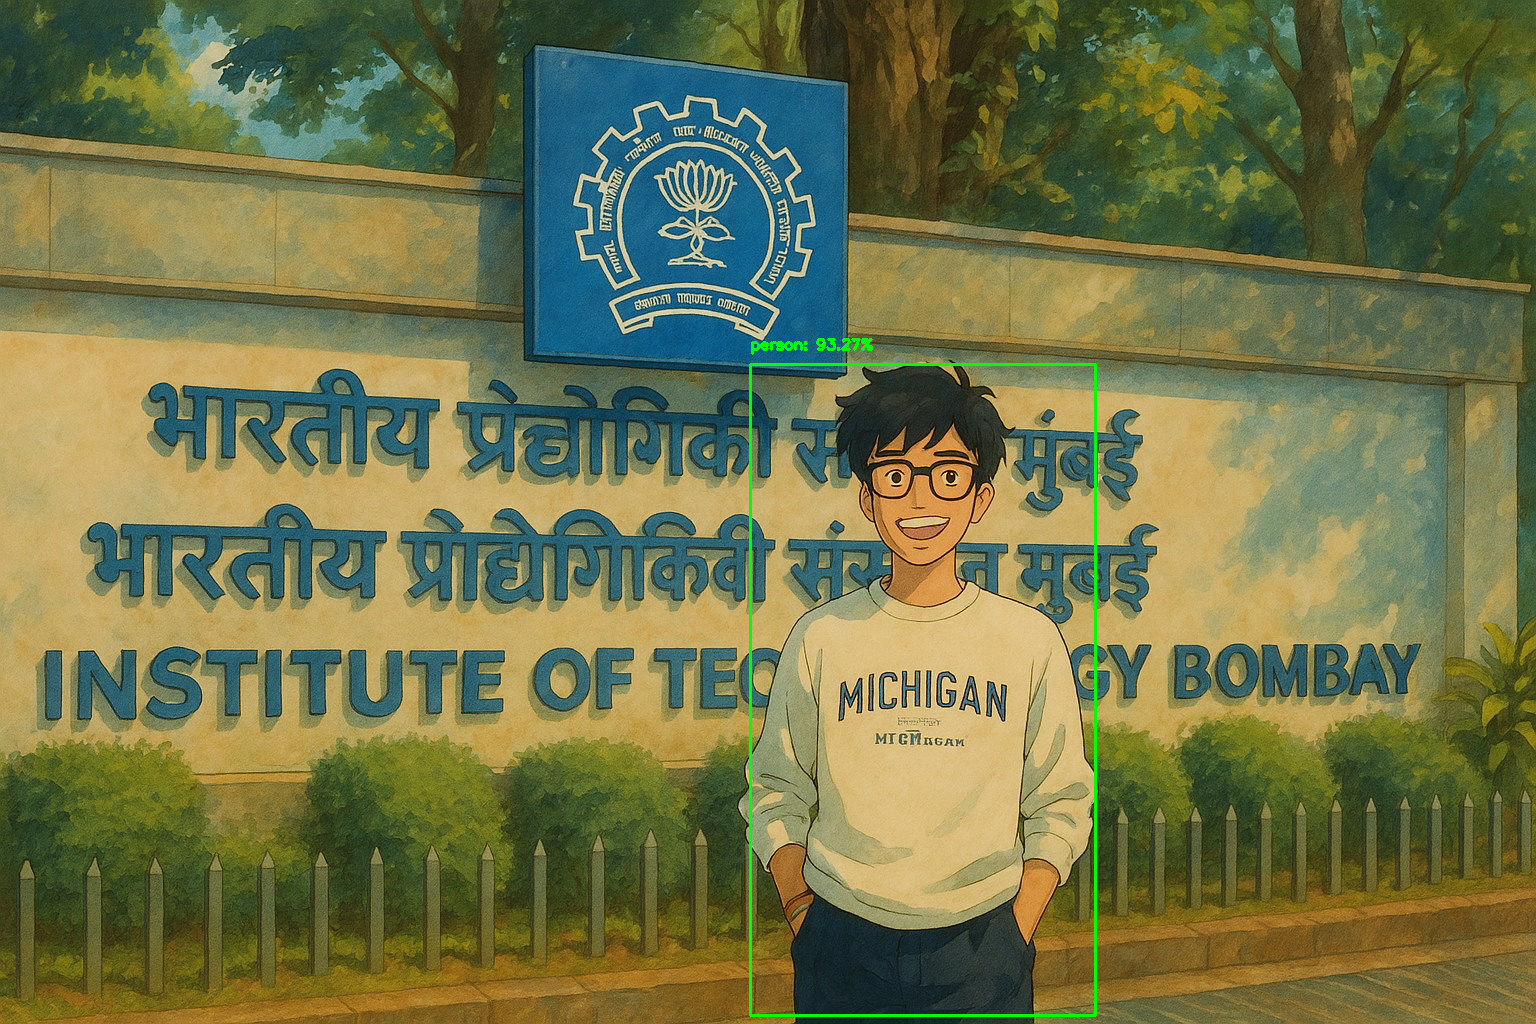

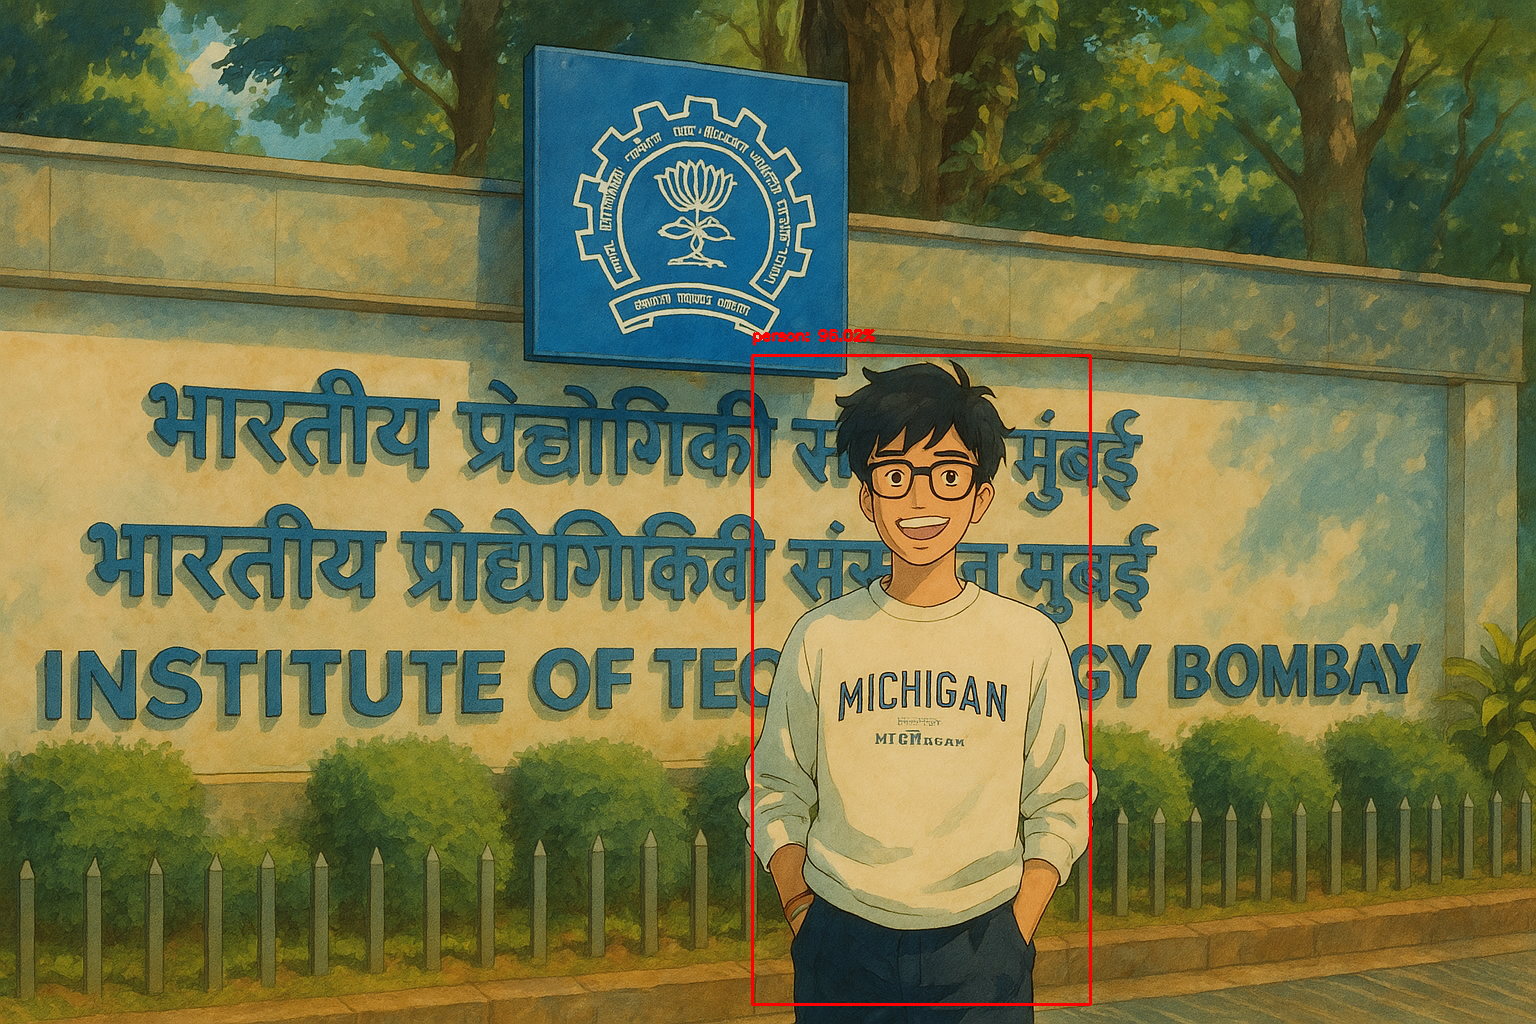

In [9]:
!wget -O MobileNetSSD_deploy.prototxt https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/voc/MobileNetSSD_deploy.prototxt
!wget -O MobileNetSSD_deploy.caffemodel https://raw.githubusercontent.com/nikmart/pi-object-detection/master/MobileNetSSD_deploy.caffemodel
!wget -c https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -c https://pjreddie.com/media/files/yolov3.weights
!wget -c https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
from google.colab import files
import os

print(os.listdir("."))

ssd_prototxt = "MobileNetSSD_deploy.prototxt"
ssd_model = "MobileNetSSD_deploy.caffemodel"
ssd_classes = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
ssd_net = cv2.dnn.readNetFromCaffe(ssd_prototxt, ssd_model)

yolo_config = "yolov3.cfg"
yolo_weights = "yolov3.weights"
yolo_names = "coco.names"
with open(yolo_names, "r") as f:
    yolo_classes = [line.strip() for line in f.readlines()]
yolo_net = cv2.dnn.readNetFromDarknet(yolo_config, yolo_weights)
ln = yolo_net.getLayerNames()
unconnected = yolo_net.getUnconnectedOutLayers()
yolo_output_layers = [ln[i - 1] if isinstance(i, (int, np.integer)) else ln[i[0] - 1] for i in unconnected]

def draw_boxes(image, boxes, confidences, classIDs, classes, color):
    for i, box in enumerate(boxes):
        (startX, startY, endX, endY) = box
        label = "{}: {:.2f}%".format(classes[classIDs[i]], confidences[i] * 100)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def detect_objects(image_path):
    image = cv2.imread(image_path)
    (H, W) = image.shape[:2]
    image_ssd = image.copy()
    image_yolo = image.copy()
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)
    ssd_net.setInput(blob)
    start = time.time()
    detections = ssd_net.forward()
    end = time.time()
    print("SSD inference time: {:.2f} seconds".format(end - start))
    boxes = []
    confidences = []
    classIDs = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = box.astype("int")
            boxes.append((startX, startY, endX, endY))
            confidences.append(float(confidence))
            classIDs.append(idx)
    draw_boxes(image_ssd, boxes, confidences, classIDs, ssd_classes, (0, 255, 0))
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    start = time.time()
    layerOutputs = yolo_net.forward(yolo_output_layers)
    end = time.time()
    print("YOLO inference time: {:.2f} seconds".format(end - start))
    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    final_boxes = []
    final_confidences = []
    final_classIDs = []
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y, w, h) = boxes[i]
            final_boxes.append((x, y, x+w, y+h))
            final_confidences.append(confidences[i])
            final_classIDs.append(classIDs[i])
    draw_boxes(image_yolo, final_boxes, final_confidences, final_classIDs, yolo_classes, (0, 0, 255))
    cv2_imshow(image_ssd)
    cv2_imshow(image_yolo)

uploaded_images = files.upload()
for fn in uploaded_images.keys():
    print('Processing file:', fn)
    detect_objects(fn)
